In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
%pylab inline
%config InlineBackends.figure_formats=['retina']

import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import tensorflow as tf

#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

sns.set()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Populating the interactive namespace from numpy and matplotlib
/kaggle/input/bikerslogistics/sample_submission.csv
/kaggle/input/bikerslogistics/Train.csv
/kaggle/input/bikerslogistics/test.csv


# Data Exploration

In [2]:
train_dataset = pd.read_csv('/kaggle/input/bikerslogistics/Train.csv')
test_dataset = pd.read_csv('/kaggle/input/bikerslogistics/test.csv')
train_dataset.head()

,User_ID,Tranport_Vehicle,Platform,Purpose,Order_Day_of_Month,Order_Week_of_Month,Time_of_Order,Order_Confirm_Day_of_Month,Order_Confirm_Day_of_Weekday,Time_of_Confirmation,...,Delivery_Weekday,Delivery_Time,DistanceCovered_KM,Temperation,Precipitation_in_millimeters,Latitude_Pickup,Longitude_Pickup,Latitude_Destination,Longitude_Destination,Time_Elapsed_from_Pickup_to_Delivery_in_Min
0,UserLogger_7277,Motorcycle,P3,Commercial,27,1,9:18:22 AM,27,1,9:18:42 AM,...,1,10:11:30 AM,6,20.9,1.0,-1.285772,36.808806,-1.296310,36.768822,23.47
1,UserLogger_1281,Motorcycle,P3,Commercial,25,1,12:07:04 PM,25,1,12:08:36 PM,...,1,1:02:09 PM,9,29.9,NaN,-1.229148,36.844029,-1.252492,36.865620,16.90
2,UserLogger_2566,Motorcycle,P3,Commercial,12,6,1:20:11 PM,12,6,1:34:44 PM,...,6,2:20:10 PM,9,28.5,NaN,-1.318062,36.849326,-1.265715,36.823815,21.83
3,UserLogger_11805,Motorcycle,P3,Commercial,28,4,11:13:53 AM,28,4,11:14:07 AM,...,4,11:53:23 AM,9,26.8,NaN,-1.263818,36.793006,-1.300406,36.829741,0.05
4,UserLogger_15199,Motorcycle,P3,Commercial,12,2,1:41:02 PM,12,2,1:41:57 PM,...,2,3:12:49 PM,7,30.1,NaN,-1.263813,36.784977,-1.294875,36.793891,27.57


In [3]:
test_dataset.head()

,User_ID,Tranport_Vehicle,Platform,Purpose,Order_Day_of_Month,Order_Week_of_Month,Time_of_Order,Order_Confirm_Day_of_Month,Order_Confirm_Day_of_Weekday,Time_of_Confirmation,...,Delivery_MonthDay,Delivery_Weekday,Delivery_Time,DistanceCovered_KM,Temperation,Precipitation_in_millimeters,Latitude_Pickup,Longitude_Pickup,Latitude_Destination,Longitude_Destination
0,UserLogger_6224,Motorcycle,P3,Commercial,4,1,3:08:18 PM,4,1,3:10:19 PM,...,4,1,4:01:26 PM,13,NaN,NaN,-1.255189,36.782203,-1.320822,36.829574
1,UserLogger_16205,Motorcycle,P1,Personal,13,5,3:34:11 PM,13,5,3:35:44 PM,...,13,5,4:21:44 PM,13,22.1,NaN,-1.240620,36.773649,-1.294744,36.762489
2,UserLogger_17099,Motorcycle,P3,Commercial,11,1,10:18:09 AM,11,1,10:18:18 AM,...,11,1,10:55:02 AM,11,29.6,NaN,-1.316711,36.830156,-1.263818,36.793006
3,UserLogger_9892,Motorcycle,P3,Commercial,5,2,4:45:37 PM,5,2,4:48:44 PM,...,5,2,6:12:00 PM,21,28.2,NaN,-1.286018,36.897534,-1.301201,36.764868
4,UserLogger_8487,Motorcycle,P3,Commercial,11,5,3:56:56 PM,11,5,3:57:09 PM,...,11,5,4:27:57 PM,11,25.4,NaN,-1.331619,36.847976,-1.293515,36.897607


In [4]:
print(train_dataset.shape)
len(train_dataset['User_ID'].unique())

(14840, 27)


14840

We will be removing the User_ID and Tranport_Vehicle as both will not be contributing any value to our prediction. Tranport_Vehicle is just one value while User_ID here cannot cause or have an effect to the predicting value

In [5]:
train_dataset = train_dataset.drop(['User_ID', 'Tranport_Vehicle'], axis=1)
test_dataset = test_dataset.drop(['User_ID', 'Tranport_Vehicle'], axis=1)

In [6]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14840 entries, 0 to 14839
Data columns (total 25 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Platform                                     14840 non-null  object 
 1   Purpose                                      14840 non-null  object 
 2   Order_Day_of_Month                           14840 non-null  int64  
 3   Order_Week_of_Month                          14840 non-null  int64  
 4   Time_of_Order                                14840 non-null  object 
 5   Order_Confirm_Day_of_Month                   14840 non-null  int64  
 6   Order_Confirm_Day_of_Weekday                 14840 non-null  int64  
 7   Time_of_Confirmation                         14840 non-null  object 
 8   Arrival_At_Pickup_MonthDay                   14840 non-null  int64  
 9   Arrival_At_Pickup_Weekday                    14840 non-null  int64  
 10

From the above, we can see Temperation and Precipitation_in_millimeters have null values.

<AxesSubplot:>

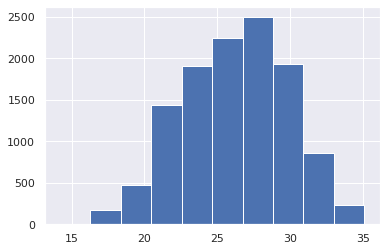

In [7]:
train_dataset['Temperation'].hist()

In [8]:
train_dataset['Temperation'].skew(axis = 0, skipna = True)

-0.14180063954804786

From the above histogram and the skew value shows the Temperation is symmetrical (not skewed) as the skewness is between -0.5 and 0.5 and the histogram is bell curved and well centered. 

Therefore we will be replacing the missing values in Temperation with mean while replacing the missing value in Precipitation_in_millimeters with 0 or 0.5. This is because we would assume the weather was fairly dry and according to https://www.climatestotravel.com/climate/nigeria, this implies the precipitation value would be between 0 and 0.5. We will be bucketising this column so it 0 or 0.5 would be considered same. We will be choosing 0

In [9]:
train_dataset['Temperation'] = train_dataset['Temperation'].fillna(train_dataset['Temperation'].mean())
train_dataset['Precipitation_in_millimeters'] = train_dataset['Precipitation_in_millimeters'].fillna(0)

In [10]:
test_dataset['Temperation'] = test_dataset['Temperation'].fillna(test_dataset['Temperation'].mean())
test_dataset['Precipitation_in_millimeters'] = test_dataset['Precipitation_in_millimeters'].fillna(0)

In [11]:
# checking again to be sure no missing value
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14840 entries, 0 to 14839
Data columns (total 25 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Platform                                     14840 non-null  object 
 1   Purpose                                      14840 non-null  object 
 2   Order_Day_of_Month                           14840 non-null  int64  
 3   Order_Week_of_Month                          14840 non-null  int64  
 4   Time_of_Order                                14840 non-null  object 
 5   Order_Confirm_Day_of_Month                   14840 non-null  int64  
 6   Order_Confirm_Day_of_Weekday                 14840 non-null  int64  
 7   Time_of_Confirmation                         14840 non-null  object 
 8   Arrival_At_Pickup_MonthDay                   14840 non-null  int64  
 9   Arrival_At_Pickup_Weekday                    14840 non-null  int64  
 10

In [12]:
train_dataset.describe()

,Order_Day_of_Month,Order_Week_of_Month,Order_Confirm_Day_of_Month,Order_Confirm_Day_of_Weekday,Arrival_At_Pickup_MonthDay,Arrival_At_Pickup_Weekday,Pickup_MonthDay,Pickup_WeekDay,Delivery_MonthDay,Delivery_Weekday,DistanceCovered_KM,Temperation,Precipitation_in_millimeters,Latitude_Pickup,Longitude_Pickup,Latitude_Destination,Longitude_Destination,Time_Elapsed_from_Pickup_to_Delivery_in_Min
count,14840.000000,14840.000000,14840.000000,14840.000000,14840.000000,14840.000000,14840.000000,14840.000000,14840.000000,14840.000000,14840.000000,14840.000000,14840.000000,14840.000000,14840.000000,14840.000000,14840.000000,14840.000000
mean,15.623720,3.237803,15.623854,3.237938,15.623854,3.237938,15.623854,3.237938,15.623854,3.237938,9.528639,26.238222,0.212244,-1.281615,36.811004,-1.282445,36.811177,25.943871
std,8.781359,1.564865,8.781303,1.564845,8.781303,1.564845,8.781303,1.564845,8.781303,1.564845,5.663128,3.224467,3.090223,0.030553,0.037578,0.034768,0.044787,16.419993
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,14.200000,0.000000,-1.433256,36.653621,-1.423840,36.606594,0.020000
25%,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,5.000000,24.400000,0.000000,-1.300921,36.784605,-1.301201,36.785599,14.730000
50%,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,8.000000,26.238222,0.000000,-1.279395,36.806969,-1.284467,36.807943,22.920000
75%,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,13.000000,28.200000,0.000000,-1.257147,36.829721,-1.261252,36.829529,33.980000
max,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,49.000000,35.100000,99.100000,-1.147170,36.991046,-1.054634,37.012030,131.380000


from our description, there are no outliers as all maximum and minimum vaues are all in-bound

In [13]:
train_dataset.head()

,Platform,Purpose,Order_Day_of_Month,Order_Week_of_Month,Time_of_Order,Order_Confirm_Day_of_Month,Order_Confirm_Day_of_Weekday,Time_of_Confirmation,Arrival_At_Pickup_MonthDay,Arrival_At_Pickup_Weekday,...,Delivery_Weekday,Delivery_Time,DistanceCovered_KM,Temperation,Precipitation_in_millimeters,Latitude_Pickup,Longitude_Pickup,Latitude_Destination,Longitude_Destination,Time_Elapsed_from_Pickup_to_Delivery_in_Min
0,P3,Commercial,27,1,9:18:22 AM,27,1,9:18:42 AM,27,1,...,1,10:11:30 AM,6,20.9,1.0,-1.285772,36.808806,-1.296310,36.768822,23.47
1,P3,Commercial,25,1,12:07:04 PM,25,1,12:08:36 PM,25,1,...,1,1:02:09 PM,9,29.9,0.0,-1.229148,36.844029,-1.252492,36.865620,16.90
2,P3,Commercial,12,6,1:20:11 PM,12,6,1:34:44 PM,12,6,...,6,2:20:10 PM,9,28.5,0.0,-1.318062,36.849326,-1.265715,36.823815,21.83
3,P3,Commercial,28,4,11:13:53 AM,28,4,11:14:07 AM,28,4,...,4,11:53:23 AM,9,26.8,0.0,-1.263818,36.793006,-1.300406,36.829741,0.05
4,P3,Commercial,12,2,1:41:02 PM,12,2,1:41:57 PM,12,2,...,2,3:12:49 PM,7,30.1,0.0,-1.263813,36.784977,-1.294875,36.793891,27.57


In [14]:
# Let us convert our time columns to 24-hour time
time_cols = ['Time_of_Order', 'Time_of_Confirmation', 'Arrival_at_Pickup_Time', 'Pickup_Time', 'Delivery_Time']
#datem = datetime.date(1, 1, 1)
for time_col in train_dataset[time_cols]:
    train_dataset[time_col] = pd.to_datetime(train_dataset[time_col]).dt.time

In [15]:
#Calculating Time Difference From One Point To The Other In Minutes and storing them as new columns
date = datetime.date(1, 1, 1)

count = 2
for i in range(len(time_cols)):
    if i+1 == len(time_cols):
        break;
    time_elapsed = []
    for j in range(len(train_dataset[time_cols[i]])):
        datetime1 = datetime.datetime.combine(date, train_dataset[time_cols[i]][j])
        datetime2 = datetime.datetime.combine(date, train_dataset[time_cols[i+1]][j])
        time_d = datetime2 - datetime1
        time_d_min = time_d / datetime.timedelta(minutes=1)
        time_elapsed.append(time_d_min)
        
    if count == 2:
        train_dataset['Conf_Order_Diff'] = time_elapsed
    elif count == 3:
        train_dataset['Arrival_Conf_Diff'] = time_elapsed
    elif count == 4:
        train_dataset['Pickup_Arrival_Diff'] = time_elapsed
    else:
        train_dataset['Deliver_Pickup_Diff'] = time_elapsed
    count += 1

In [16]:
train_dataset.head()

,Platform,Purpose,Order_Day_of_Month,Order_Week_of_Month,Time_of_Order,Order_Confirm_Day_of_Month,Order_Confirm_Day_of_Weekday,Time_of_Confirmation,Arrival_At_Pickup_MonthDay,Arrival_At_Pickup_Weekday,...,Precipitation_in_millimeters,Latitude_Pickup,Longitude_Pickup,Latitude_Destination,Longitude_Destination,Time_Elapsed_from_Pickup_to_Delivery_in_Min,Conf_Order_Diff,Arrival_Conf_Diff,Pickup_Arrival_Diff,Deliver_Pickup_Diff
0,P3,Commercial,27,1,09:18:22,27,1,09:18:42,27,1,...,1.0,-1.285772,36.808806,-1.296310,36.768822,23.47,0.333333,27.683333,1.650000,23.466667
1,P3,Commercial,25,1,12:07:04,25,1,12:08:36,25,1,...,0.0,-1.229148,36.844029,-1.252492,36.865620,16.90,1.533333,32.666667,3.983333,16.900000
2,P3,Commercial,12,6,13:20:11,12,6,13:34:44,12,6,...,0.0,-1.318062,36.849326,-1.265715,36.823815,21.83,14.550000,20.116667,3.483333,21.833333
3,P3,Commercial,28,4,11:13:53,28,4,11:14:07,28,4,...,0.0,-1.263818,36.793006,-1.300406,36.829741,0.05,0.233333,11.416667,27.800000,0.050000
4,P3,Commercial,12,2,13:41:02,12,2,13:41:57,12,2,...,0.0,-1.263813,36.784977,-1.294875,36.793891,27.57,0.916667,58.866667,4.433333,27.566667


In [17]:
# Let us convert our time columes to day type category.
# Since we now have the time difference in minutes, we can go ahead and categorise the time of day this way

for time_col in train_dataset[time_cols]:
    train_dataset[time_col] = train_dataset[time_col].apply(lambda x: '2017-08-10 ' + str(x))
    train_dataset[time_col] = train_dataset[time_col].apply(lambda x: 'Late Night' if x[11:13] >= '00' and x[11:13] < '04' else
                                                            ('Early Morning'if x[11:13] >= '04' and x[11:13] < '08' else 
                                                             ('Morning' if x[11:13] >= '08' and x[11:13] < '12' else 
                                                              ('Afternoon' if x[11:13] >= '12' and x[11:13] < '16' else 
                                                               ('Evening' if x[11:13] >= '16' and x[11:13] < '20' else 'Night')
                                                              )
                                                             )
                                                            )
                                                           )
    

In [18]:
train_dataset.head()

,Platform,Purpose,Order_Day_of_Month,Order_Week_of_Month,Time_of_Order,Order_Confirm_Day_of_Month,Order_Confirm_Day_of_Weekday,Time_of_Confirmation,Arrival_At_Pickup_MonthDay,Arrival_At_Pickup_Weekday,...,Precipitation_in_millimeters,Latitude_Pickup,Longitude_Pickup,Latitude_Destination,Longitude_Destination,Time_Elapsed_from_Pickup_to_Delivery_in_Min,Conf_Order_Diff,Arrival_Conf_Diff,Pickup_Arrival_Diff,Deliver_Pickup_Diff
0,P3,Commercial,27,1,Morning,27,1,Morning,27,1,...,1.0,-1.285772,36.808806,-1.296310,36.768822,23.47,0.333333,27.683333,1.650000,23.466667
1,P3,Commercial,25,1,Afternoon,25,1,Afternoon,25,1,...,0.0,-1.229148,36.844029,-1.252492,36.865620,16.90,1.533333,32.666667,3.983333,16.900000
2,P3,Commercial,12,6,Afternoon,12,6,Afternoon,12,6,...,0.0,-1.318062,36.849326,-1.265715,36.823815,21.83,14.550000,20.116667,3.483333,21.833333
3,P3,Commercial,28,4,Morning,28,4,Morning,28,4,...,0.0,-1.263818,36.793006,-1.300406,36.829741,0.05,0.233333,11.416667,27.800000,0.050000
4,P3,Commercial,12,2,Afternoon,12,2,Afternoon,12,2,...,0.0,-1.263813,36.784977,-1.294875,36.793891,27.57,0.916667,58.866667,4.433333,27.566667


In [19]:
#testing to see the values
train_dataset['Time_of_Order'].unique()

array(['Morning', 'Afternoon', 'Evening', 'Early Morning', 'Night',
       'Late Night'], dtype=object)

In [20]:
train_dataset.shape

(14840, 29)

For Test Data

In [21]:
for time_col in test_dataset[time_cols]:
    test_dataset[time_col] = pd.to_datetime(test_dataset[time_col]).dt.time

In [22]:
date = datetime.date(1, 1, 1)

count = 2
for i in range(len(time_cols)):
    if i+1 == len(time_cols):
        break;
    time_elapsed = []
    for j in range(len(test_dataset[time_cols[i]])):
        datetime1 = datetime.datetime.combine(date, test_dataset[time_cols[i]][j])
        datetime2 = datetime.datetime.combine(date, test_dataset[time_cols[i+1]][j])
        time_d = datetime2 - datetime1
        time_d_min = time_d / datetime.timedelta(minutes=1)
        time_elapsed.append(time_d_min)
        
    if count == 2:
        test_dataset['Conf_Order_Diff'] = time_elapsed
    elif count == 3:
        test_dataset['Arrival_Conf_Diff'] = time_elapsed
    elif count == 4:
        test_dataset['Pickup_Arrival_Diff'] = time_elapsed
    else:
        test_dataset['Deliver_Pickup_Diff'] = time_elapsed
    count += 1

In [23]:
# Let us convert our time columes to day type category

for time_col in test_dataset[time_cols]:
    test_dataset[time_col] = test_dataset[time_col].apply(lambda x: '2017-08-10 ' + str(x))
    test_dataset[time_col] = test_dataset[time_col].apply(lambda x: 'Late Night' if x[11:13] >= '00' and x[11:13] < '04' else
                                                            ('Early Morning'if x[11:13] >= '04' and x[11:13] < '08' else 
                                                             ('Morning' if x[11:13] >= '08' and x[11:13] < '12' else 
                                                              ('Afternoon' if x[11:13] >= '12' and x[11:13] < '16' else 
                                                               ('Evening' if x[11:13] >= '16' and x[11:13] < '20' else 'Night')
                                                              )
                                                             )
                                                            )
                                                           )
    

In [24]:
test_dataset.head()

,Platform,Purpose,Order_Day_of_Month,Order_Week_of_Month,Time_of_Order,Order_Confirm_Day_of_Month,Order_Confirm_Day_of_Weekday,Time_of_Confirmation,Arrival_At_Pickup_MonthDay,Arrival_At_Pickup_Weekday,...,Temperation,Precipitation_in_millimeters,Latitude_Pickup,Longitude_Pickup,Latitude_Destination,Longitude_Destination,Conf_Order_Diff,Arrival_Conf_Diff,Pickup_Arrival_Diff,Deliver_Pickup_Diff
0,P3,Commercial,4,1,Afternoon,4,1,Afternoon,4,1,...,26.306888,0.0,-1.255189,36.782203,-1.320822,36.829574,2.016667,12.483333,3.833333,34.800000
1,P1,Personal,13,5,Afternoon,13,5,Afternoon,13,5,...,22.100000,0.0,-1.240620,36.773649,-1.294744,36.762489,1.550000,11.316667,5.850000,28.833333
2,P3,Commercial,11,1,Morning,11,1,Morning,11,1,...,29.600000,0.0,-1.316711,36.830156,-1.263818,36.793006,0.150000,0.083333,36.266667,0.383333
3,P3,Commercial,5,2,Evening,5,2,Evening,5,2,...,28.200000,0.0,-1.286018,36.897534,-1.301201,36.764868,3.116667,18.900000,8.400000,55.966667
4,P3,Commercial,11,5,Afternoon,11,5,Afternoon,11,5,...,25.400000,0.0,-1.331619,36.847976,-1.293515,36.897607,0.216667,0.083333,14.700000,16.016667


<AxesSubplot:>

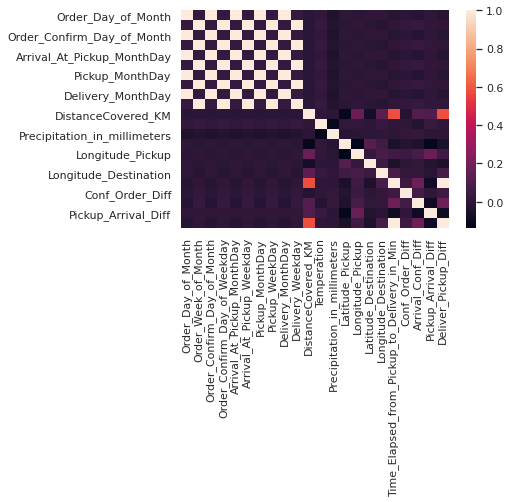

In [25]:
# Using heatmap to show interactive behaviour and patterns between features
sns.heatmap(train_dataset.corr())

One Hot Encooding the Categorical columns

In [26]:
cat_cols = ['Platform', 'Purpose', 'Order_Day_of_Month', 'Order_Week_of_Month', 'Time_of_Order', 'Order_Confirm_Day_of_Month', 'Order_Confirm_Day_of_Weekday', 'Time_of_Confirmation', 'Arrival_At_Pickup_MonthDay', 'Arrival_At_Pickup_Weekday', 'Arrival_at_Pickup_Time', 'Pickup_MonthDay', 'Pickup_WeekDay', 'Pickup_Time', 'Delivery_MonthDay', 'Delivery_Weekday', 'Delivery_Time']
y_col = 'Time_Elapsed_from_Pickup_to_Delivery_in_Min'
num_col = ['DistanceCovered_KM', 'Temperation', 'Precipitation_in_millimeters', 'Latitude_Pickup', 'Longitude_Pickup', 'Latitude_Destination', 'Longitude_Destination', 'Conf_Order_Diff', 'Arrival_Conf_Diff', 'Pickup_Arrival_Diff', 'Deliver_Pickup_Diff']

In [27]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le = LabelEncoder()
ohe = OneHotEncoder()

In [28]:
# One Hot Encoding the Train dataset
for col in cat_cols:
    dt_le = le.fit_transform(train_dataset[col]).astype(np.int)
    dt_ohe = ohe.fit_transform(dt_le.reshape(-1,1)).astype(np.int)
    train_dataset = train_dataset.drop(col, axis=1)
    
    n_cols = dt_ohe.shape[1]
    col_names = ['_'.join([col, str(x)]) for x in range(n_cols)]
    
    new_df = pd.DataFrame(dt_ohe.toarray(),
                         index=train_dataset.index,
                         columns=col_names)
    train_dataset = pd.concat([train_dataset, new_df], axis=1)

In [29]:
train_dataset.head()

,DistanceCovered_KM,Temperation,Precipitation_in_millimeters,Latitude_Pickup,Longitude_Pickup,Latitude_Destination,Longitude_Destination,Time_Elapsed_from_Pickup_to_Delivery_in_Min,Conf_Order_Diff,Arrival_Conf_Diff,...,Delivery_Weekday_3,Delivery_Weekday_4,Delivery_Weekday_5,Delivery_Weekday_6,Delivery_Time_0,Delivery_Time_1,Delivery_Time_2,Delivery_Time_3,Delivery_Time_4,Delivery_Time_5
0,6,20.9,1.0,-1.285772,36.808806,-1.296310,36.768822,23.47,0.333333,27.683333,...,0,0,0,0,0,0,0,0,1,0
1,9,29.9,0.0,-1.229148,36.844029,-1.252492,36.865620,16.90,1.533333,32.666667,...,0,0,0,0,1,0,0,0,0,0
2,9,28.5,0.0,-1.318062,36.849326,-1.265715,36.823815,21.83,14.550000,20.116667,...,0,0,1,0,1,0,0,0,0,0
3,9,26.8,0.0,-1.263818,36.793006,-1.300406,36.829741,0.05,0.233333,11.416667,...,1,0,0,0,0,0,0,0,1,0
4,7,30.1,0.0,-1.263813,36.784977,-1.294875,36.793891,27.57,0.916667,58.866667,...,0,0,0,0,1,0,0,0,0,0


Now Let us One Hot Encode test data

In [30]:
# One Hot Encoding the test dataset
for col in cat_cols:
    dt_le = le.fit_transform(test_dataset[col]).astype(np.int)
    dt_ohe = ohe.fit_transform(dt_le.reshape(-1,1)).astype(np.int)
    test_dataset = test_dataset.drop(col, axis=1)
    
    n_cols = dt_ohe.shape[1]
    col_names = ['_'.join([col, str(x)]) for x in range(n_cols)]
    
    new_df = pd.DataFrame(dt_ohe.toarray(),
                         index=test_dataset.index,
                         columns=col_names)
    test_dataset = pd.concat([test_dataset, new_df], axis=1)

In [31]:
test_dataset.head()

,DistanceCovered_KM,Temperation,Precipitation_in_millimeters,Latitude_Pickup,Longitude_Pickup,Latitude_Destination,Longitude_Destination,Conf_Order_Diff,Arrival_Conf_Diff,Pickup_Arrival_Diff,...,Delivery_Weekday_2,Delivery_Weekday_3,Delivery_Weekday_4,Delivery_Weekday_5,Delivery_Weekday_6,Delivery_Time_0,Delivery_Time_1,Delivery_Time_2,Delivery_Time_3,Delivery_Time_4
0,13,26.306888,0.0,-1.255189,36.782203,-1.320822,36.829574,2.016667,12.483333,3.833333,...,0,0,0,0,0,0,0,1,0,0
1,13,22.100000,0.0,-1.240620,36.773649,-1.294744,36.762489,1.550000,11.316667,5.850000,...,0,0,1,0,0,0,0,1,0,0
2,11,29.600000,0.0,-1.316711,36.830156,-1.263818,36.793006,0.150000,0.083333,36.266667,...,0,0,0,0,0,0,0,0,1,0
3,21,28.200000,0.0,-1.286018,36.897534,-1.301201,36.764868,3.116667,18.900000,8.400000,...,0,0,0,0,0,0,0,1,0,0
4,11,25.400000,0.0,-1.331619,36.847976,-1.293515,36.897607,0.216667,0.083333,14.700000,...,0,0,1,0,0,0,0,1,0,0


# Feature Engineering

In [32]:
X = train_dataset.drop(y_col, axis=1)
Y = train_dataset[y_col]

In [33]:
pd.DataFrame(X).head()

,DistanceCovered_KM,Temperation,Precipitation_in_millimeters,Latitude_Pickup,Longitude_Pickup,Latitude_Destination,Longitude_Destination,Conf_Order_Diff,Arrival_Conf_Diff,Pickup_Arrival_Diff,...,Delivery_Weekday_3,Delivery_Weekday_4,Delivery_Weekday_5,Delivery_Weekday_6,Delivery_Time_0,Delivery_Time_1,Delivery_Time_2,Delivery_Time_3,Delivery_Time_4,Delivery_Time_5
0,6,20.9,1.0,-1.285772,36.808806,-1.296310,36.768822,0.333333,27.683333,1.650000,...,0,0,0,0,0,0,0,0,1,0
1,9,29.9,0.0,-1.229148,36.844029,-1.252492,36.865620,1.533333,32.666667,3.983333,...,0,0,0,0,1,0,0,0,0,0
2,9,28.5,0.0,-1.318062,36.849326,-1.265715,36.823815,14.550000,20.116667,3.483333,...,0,0,1,0,1,0,0,0,0,0
3,9,26.8,0.0,-1.263818,36.793006,-1.300406,36.829741,0.233333,11.416667,27.800000,...,1,0,0,0,0,0,0,0,1,0
4,7,30.1,0.0,-1.263813,36.784977,-1.294875,36.793891,0.916667,58.866667,4.433333,...,0,0,0,0,1,0,0,0,0,0


Train-Test Split

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [36]:
x_train

,DistanceCovered_KM,Temperation,Precipitation_in_millimeters,Latitude_Pickup,Longitude_Pickup,Latitude_Destination,Longitude_Destination,Conf_Order_Diff,Arrival_Conf_Diff,Pickup_Arrival_Diff,...,Delivery_Weekday_3,Delivery_Weekday_4,Delivery_Weekday_5,Delivery_Weekday_6,Delivery_Time_0,Delivery_Time_1,Delivery_Time_2,Delivery_Time_3,Delivery_Time_4,Delivery_Time_5
6700,10,25.400000,0.0,-1.300406,36.829741,-1.299144,36.752880,11.200000,19.783333,9.500000,...,0,0,1,0,0,0,0,0,1,0
12825,4,26.238222,0.0,-1.261587,36.796781,-1.286852,36.784425,0.350000,1.583333,46.266667,...,0,0,1,0,1,0,0,0,0,0
4325,17,20.400000,16.1,-1.197126,36.806307,-1.298817,36.819857,5.233333,13.533333,26.350000,...,1,0,0,0,0,0,0,0,1,0
3219,8,26.238222,0.0,-1.255189,36.782203,-1.290402,36.822630,69.533333,4.983333,25.166667,...,1,0,0,0,1,0,0,0,0,0
7444,1,30.300000,0.0,-1.255189,36.782203,-1.262527,36.794162,8.233333,5.883333,7.150000,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,8,25.400000,0.0,-1.257147,36.795063,-1.302567,36.780349,2.333333,1.266667,10.466667,...,0,0,0,0,1,0,0,0,0,0
13418,23,26.238222,0.0,-1.370038,36.919017,-1.257147,36.795063,24.666667,8.150000,6.383333,...,0,0,0,0,1,0,0,0,0,0
5390,10,26.238222,0.0,-1.304446,36.823367,-1.255189,36.782203,1.700000,16.983333,8.633333,...,1,0,0,0,0,0,0,0,1,0
860,22,28.600000,0.0,-1.257309,36.806008,-1.341891,36.761269,0.066667,6.083333,3.766667,...,0,0,0,0,1,0,0,0,0,0


We will be using polynomial of degree 2 to transform our data and then use Ridge regression to train. This is because Ridge regression contains L2 regularization. I dont want to use L1 regularization becuase I dont want to "Zerorise" most of the coefficients so I dont cancel out a lot of features.

In [37]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [38]:
pl_feat = PolynomialFeatures(degree=2, include_bias=False)
ridge = Ridge(alpha=0.01, max_iter=100000)

In [39]:
x_train_pf = x_train.copy()
x_test_pf = x_test.copy()

x_train_pf = pl_feat.fit_transform(x_train_pf)
x_test_pf = pl_feat.transform(x_test_pf)

In [40]:
x_test_pf.shape

(4452, 28440)

In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_pf_s = scaler.fit_transform(x_train_pf)
x_test_pf_s = scaler.transform(x_test_pf)

In [42]:
y_train

6700     27.63
12825     3.52
4325     39.75
3219      0.05
7444      8.05
         ...  
5191     17.58
13418    43.90
5390     21.98
860      36.77
7270     25.12
Name: Time_Elapsed_from_Pickup_to_Delivery_in_Min, Length: 10388, dtype: float64

# Train and Evaluate

In [43]:
ridge.fit(x_train_pf_s, y_train)
ridge.coef_

array([ 0.08795694, -0.00019675,  0.00027067, ..., -0.00381322,
        0.        ,  0.001335  ])

In [44]:
print('number of coefficients not equal to 0:', (ridge.coef_!=0).sum())
print('number of coefficients equal to 0:', (ridge.coef_ == 0).sum())

number of coefficients not equal to 0: 14172
number of coefficients equal to 0: 14268


The ridge regression with alpha  0.01 still zerorised about 14 thusand coefficients

In [45]:
pred_train_ridge01 = ridge.predict(x_train_pf_s)
pred_test_ridge01 = ridge.predict(x_test_pf_s)

train_error_ridge01 = mean_squared_error(y_train, pred_train_ridge01)
test_error_ridge01 = mean_squared_error(y_test, pred_test_ridge01)
r2_ridge01 = r2_score(y_test, pred_test_ridge01)

In [46]:
print('MSE for the training set for ridge regresseion with alpha 0.01 is: {}'.format(train_error_ridge01))
print('MSE for the test set for ridge regresseion with alpha 0.01 is: {}'.format(test_error_ridge01))
print('R2 score for the Ridge regression is {}'.format(r2_ridge01))

MSE for the training set for ridge regresseion with alpha 0.01 is: 8.081736173900317e-06
MSE for the test set for ridge regresseion with alpha 0.01 is: 0.036475184646576043
R2 score for the Ridge regression is 0.9998561051309818


For Ridge with alpha 0.001

In [47]:
ridge001 = Ridge(alpha=0.001, max_iter=100000)
ridge001.fit(x_train_pf_s, y_train)
ridge001.coef_

array([ 0.03816266,  0.01225715,  0.00182735, ..., -0.00073854,
        0.        ,  0.0015703 ])

In [48]:
print('number of coefficients not equal to 0:', (ridge001.coef_!=0).sum())
print('number of coefficients equal to 0:', (ridge001.coef_ == 0).sum())

number of coefficients not equal to 0: 14172
number of coefficients equal to 0: 14268


In [49]:
pred_train_ridge001 = ridge001.predict(x_train_pf_s)
pred_test_ridge001 = ridge001.predict(x_test_pf_s)

train_error_ridge001 = mean_squared_error(y_train, pred_train_ridge001)
test_error_ridge001 = mean_squared_error(y_test, pred_test_ridge001)
r2_ridge001 = r2_score(y_test, pred_test_ridge001)

In [50]:
print('MSE for the training set for ridge regresseion with alpha 0.001 is: {}'.format(train_error_ridge001))
print('MSE for the test set for ridge regresseion with alpha 0.001 is: {}'.format(test_error_ridge001))
print('R2 score for the Ridge regression is {}'.format(r2_ridge001))

MSE for the training set for ridge regresseion with alpha 0.001 is: 6.503719065499715e-06
MSE for the test set for ridge regresseion with alpha 0.001 is: 0.04481459014769975
R2 score for the Ridge regression is 0.999823206115558


By analysing the set of errors, we can see that Ridge with alpha 0.001 is beginning to overfit as its error in training set is smaller that that of 0.01 but its error on test set is larger. same with its R2 score - slightly larger than that of 0.01.

Therefore we can agree to use the Ridge regression with alpha = 0.01 to predict the test data.

# Prediction

Now Let us Predict the test data

In [51]:
test_dataset.shape[0]

6361

We need to make the number of columns same with our training set by introducing features in training set but not in test set and setting them all to zero

In [52]:
test_dataset

,DistanceCovered_KM,Temperation,Precipitation_in_millimeters,Latitude_Pickup,Longitude_Pickup,Latitude_Destination,Longitude_Destination,Conf_Order_Diff,Arrival_Conf_Diff,Pickup_Arrival_Diff,...,Delivery_Weekday_2,Delivery_Weekday_3,Delivery_Weekday_4,Delivery_Weekday_5,Delivery_Weekday_6,Delivery_Time_0,Delivery_Time_1,Delivery_Time_2,Delivery_Time_3,Delivery_Time_4
0,13,26.306888,0.0,-1.255189,36.782203,-1.320822,36.829574,2.016667,12.483333,3.833333,...,0,0,0,0,0,0,0,1,0,0
1,13,22.100000,0.0,-1.240620,36.773649,-1.294744,36.762489,1.550000,11.316667,5.850000,...,0,0,1,0,0,0,0,1,0,0
2,11,29.600000,0.0,-1.316711,36.830156,-1.263818,36.793006,0.150000,0.083333,36.266667,...,0,0,0,0,0,0,0,0,1,0
3,21,28.200000,0.0,-1.286018,36.897534,-1.301201,36.764868,3.116667,18.900000,8.400000,...,0,0,0,0,0,0,0,1,0,0
4,11,25.400000,0.0,-1.331619,36.847976,-1.293515,36.897607,0.216667,0.083333,14.700000,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6356,14,26.500000,0.0,-1.237705,36.766328,-1.310627,36.819216,0.416667,12.933333,21.466667,...,1,0,0,0,0,0,0,1,0,0
6357,7,26.306888,0.0,-1.321019,36.841055,-1.285064,36.813096,2.500000,14.650000,1.983333,...,1,0,0,0,0,0,0,0,1,0
6358,14,26.306888,0.0,-1.258414,36.804800,-1.207546,36.791398,1.966667,11.150000,10.983333,...,0,0,1,0,0,0,0,1,0,0
6359,5,26.306888,0.0,-1.260093,36.808869,-1.265715,36.823815,0.733333,14.266667,16.266667,...,1,0,0,0,0,0,0,0,1,0


In [53]:
train_cols = sorted(train_dataset)
len(train_cols)

238

In [54]:
test_cols = sorted(test_dataset)
len(test_cols)

232

In [55]:
col_dif = []
for col in train_cols:
    if col not in test_cols:
        col_dif.append(col)

In [56]:
col_dif.remove('Time_Elapsed_from_Pickup_to_Delivery_in_Min')

In [57]:
col_dif

['Arrival_at_Pickup_Time_5',
 'Delivery_Time_5',
 'Pickup_Time_5',
 'Time_of_Confirmation_5',
 'Time_of_Order_5']

In [58]:
df_0 = pd.DataFrame(0, index=range(test_dataset.shape[0]), columns=col_dif)

In [59]:
df_0.shape

(6361, 5)

In [60]:
new_test_dataset = pd.concat([test_dataset, df_0], axis=1)

In [61]:
new_test_dataset.shape

(6361, 237)

In [62]:
test_p = new_test_dataset.copy()

test_p = pl_feat.transform(test_p)

In [63]:
test_p.shape

(6361, 28440)

In [64]:
test_predict = ridge.predict(test_p)
test_predict

array([2557.55779777, 2093.42096471,  -38.92398566, ..., 2176.96298497,
        663.30589136, 3967.50447328])

Let us scale test to see if there will be any difference

In [65]:
test_p_s = scaler.transform(test_p)

In [66]:
test_p_s.shape

(6361, 28440)

In [67]:
test_predict2 = ridge.predict(test_p_s)
test_predict2

array([33.0576783 , 27.93183313,  1.20164675, ..., 28.88803245,
        8.21931878, 47.44248431])

I think the test prediction is better with scale

In [68]:
pred_pred = pd.DataFrame(test_predict2)
pred_pred

,0
0,33.057678
1,27.931833
2,1.201647
3,54.683485
4,15.550877
...,...
6356,55.184678
6357,21.684355
6358,28.888032
6359,8.219319


In [69]:
sample_sub = pd.read_csv('/kaggle/input/bikerslogistics/sample_submission.csv')

In [70]:
sample_sub.head()

,User_ID,Time_Elapsed_from_Pickup_to_Delivery_in_Min
0,UserLogger_6224,10.8
1,UserLogger_16205,10.8
2,UserLogger_17099,10.8
3,UserLogger_9892,10.8
4,UserLogger_8487,10.8


In [71]:
submitted_prediction_data = pd.read_csv('/kaggle/input/bikerslogistics/test.csv')

In [72]:
submitted_prediction_data.head()

,User_ID,Tranport_Vehicle,Platform,Purpose,Order_Day_of_Month,Order_Week_of_Month,Time_of_Order,Order_Confirm_Day_of_Month,Order_Confirm_Day_of_Weekday,Time_of_Confirmation,...,Delivery_MonthDay,Delivery_Weekday,Delivery_Time,DistanceCovered_KM,Temperation,Precipitation_in_millimeters,Latitude_Pickup,Longitude_Pickup,Latitude_Destination,Longitude_Destination
0,UserLogger_6224,Motorcycle,P3,Commercial,4,1,3:08:18 PM,4,1,3:10:19 PM,...,4,1,4:01:26 PM,13,NaN,NaN,-1.255189,36.782203,-1.320822,36.829574
1,UserLogger_16205,Motorcycle,P1,Personal,13,5,3:34:11 PM,13,5,3:35:44 PM,...,13,5,4:21:44 PM,13,22.1,NaN,-1.240620,36.773649,-1.294744,36.762489
2,UserLogger_17099,Motorcycle,P3,Commercial,11,1,10:18:09 AM,11,1,10:18:18 AM,...,11,1,10:55:02 AM,11,29.6,NaN,-1.316711,36.830156,-1.263818,36.793006
3,UserLogger_9892,Motorcycle,P3,Commercial,5,2,4:45:37 PM,5,2,4:48:44 PM,...,5,2,6:12:00 PM,21,28.2,NaN,-1.286018,36.897534,-1.301201,36.764868
4,UserLogger_8487,Motorcycle,P3,Commercial,11,5,3:56:56 PM,11,5,3:57:09 PM,...,11,5,4:27:57 PM,11,25.4,NaN,-1.331619,36.847976,-1.293515,36.897607


In [73]:
for col in submitted_prediction_data.columns.tolist():
    if col != 'User_ID':
        submitted_prediction_data = submitted_prediction_data.drop(col, axis=1)
        
submitted_prediction_data.head()

,User_ID
0,UserLogger_6224
1,UserLogger_16205
2,UserLogger_17099
3,UserLogger_9892
4,UserLogger_8487


In [74]:
submitted_prediction_data = pd.concat([submitted_prediction_data, pred_pred], axis=1)
submitted_prediction_data.head()

,User_ID,0
0,UserLogger_6224,33.057678
1,UserLogger_16205,27.931833
2,UserLogger_17099,1.201647
3,UserLogger_9892,54.683485
4,UserLogger_8487,15.550877


In [75]:
submitted_prediction_data = submitted_prediction_data.rename(columns={0:'Time_Elapsed_from_Pickup_to_Delivery_in_Min'})

In [76]:
submitted_prediction_data.head()

,User_ID,Time_Elapsed_from_Pickup_to_Delivery_in_Min
0,UserLogger_6224,33.057678
1,UserLogger_16205,27.931833
2,UserLogger_17099,1.201647
3,UserLogger_9892,54.683485
4,UserLogger_8487,15.550877


In [77]:
submitted_prediction_data.to_csv('submitted_prediction.csv',index=False)